In [1]:
cd ..

/Users/kimyoungh/GoogleDrive/rich/main/rich


In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyupbit

from data_processing.trading_sequence_generator import TradingSequenceGenerator

%load_ext autoreload
%autoreload 2

In [3]:
with open('train_data/trading_bc_transformer/train_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [4]:
dataset.keys()

dict_keys(['action_series', 'rets_series', 'rew_series', 'val_series', 'date_series', 'observations'])

In [5]:
dataset['date_series']

array(['2021-12-07T16:00:00.000000000', '2021-12-07T17:00:00.000000000',
       '2021-12-07T18:00:00.000000000', ...,
       '2022-12-16T22:00:00.000000000', '2022-12-16T23:00:00.000000000',
       '2022-12-17T00:00:00.000000000'], dtype='datetime64[ns]')

In [6]:
help(pyupbit.get_ohlcv)

Help on function get_ohlcv in module pyupbit.quotation_api:

get_ohlcv(ticker='KRW-BTC', interval='day', count=200, to=None, period=0.1)



In [7]:
price = pyupbit.get_ohlcv('KRW-XRP', interval='minute60',
                        count=24 * 365 + 24 + (24 * 10))

In [8]:
price

,open,high,low,close,volume,value
2021-12-14 12:00:00,986.0,991.0,980.0,983.0,1.167387e+07,1.149955e+10
2021-12-14 13:00:00,983.0,989.0,979.0,981.0,1.005022e+07,9.883760e+09
2021-12-14 14:00:00,981.0,985.0,972.0,973.0,1.410482e+07,1.381384e+10
2021-12-14 15:00:00,973.0,979.0,956.0,965.0,3.209986e+07,3.096618e+10
2021-12-14 16:00:00,966.0,980.0,964.0,976.0,1.439310e+07,1.398367e+10
...,...,...,...,...,...,...
2022-12-25 15:00:00,454.0,455.0,454.0,454.0,2.170848e+06,9.861480e+08
2022-12-25 16:00:00,454.0,455.0,453.0,453.0,2.291211e+06,1.040218e+09
2022-12-25 17:00:00,453.0,454.0,451.0,452.0,4.799333e+06,2.171644e+09
2022-12-25 18:00:00,452.0,454.0,452.0,453.0,2.090433e+06,9.463552e+08


<AxesSubplot:>

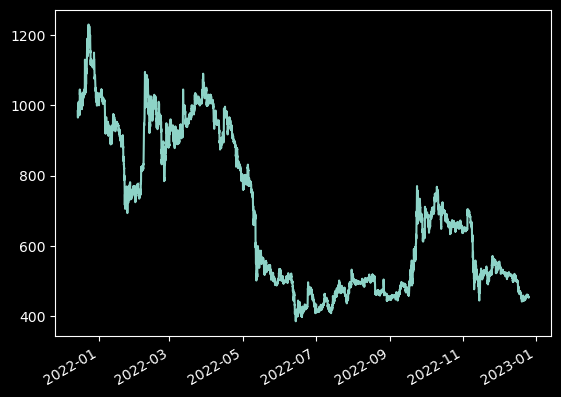

In [9]:
price['close'].plot()

<AxesSubplot:>

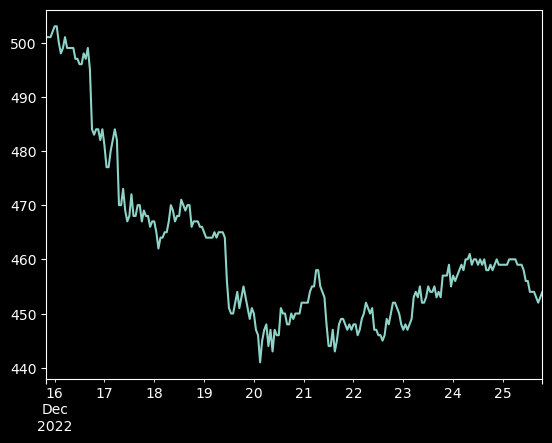

In [10]:
price['close'].iloc[-240:].plot()

In [11]:
tsg = TradingSequenceGenerator(price, trading_period=24, fee=0.001, decay=0.99)

In [12]:
dataset = tsg.generate_overall_dataset(
    pick_num=4, sample_num=5, temp=100000, rn_calc=False)

best done!


/Users/kimyoungh/GoogleDrive/rich/main/rich/data_processing/trading_sequence_generator.py:129: RuntimeWarning: invalid value encountered in true_divide
  o_values = (o_values - o_min) / (o_max - o_min)


In [14]:
dataset['observations'].shape

(8977, 24, 9)

In [21]:
dataset['action_series'].shape

(8977, 5, 24)

In [28]:
ohlc = tsg.price[['open', 'high', 'low', 'close']].iloc[tsg.window-1:].copy()
o_values = ohlc.values
o_max = o_values.max(axis=1, keepdims=True)
o_min = o_values.min(axis=1, keepdims=True)

o_values = (o_values - o_min) / (o_max - o_min + tsg.eps)
ohlc = pd.DataFrame(o_values, columns=ohlc.columns,
                    index=ohlc.index)

pmax = tsg.price.rolling(tsg.window).max().dropna()
pmin = tsg.price.rolling(tsg.window).min().dropna()
pnorm = (tsg.price.iloc[tsg.window-1:] - pmin) / (pmax - pmin + tsg.eps)

pnorm = pd.concat((ohlc, pnorm), axis=1)

obs = pnorm.values

observations = []
for i in range(obs.shape[0] - tsg.trading_period):
    observations.append(obs[i:i+tsg.trading_period])

observations = np.stack(observations, axis=0)
dataset['observations'] = observations

In [29]:
observations.shape

(8977, 24, 9)

In [30]:
dataset['rets_series'].shape

(8977, 5, 24)

In [31]:
dataset.keys()

dict_keys(['action_series', 'rets_series', 'rew_series', 'val_series', 'date_series', 'observations'])

In [32]:
for key, data in dataset.items():
    print(key, data.shape)

action_series (8977, 5, 24)
rets_series (8977, 5, 24)
rew_series (8977, 5, 24)
val_series (8977, 5, 24)
date_series (8977,)
observations (8977, 24, 9)


<AxesSubplot:>

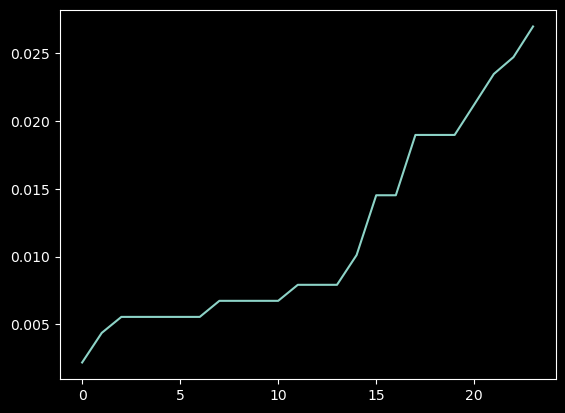

In [33]:
((1 + pd.Series(dataset['rets_series'][-1][3])).cumprod() - 1).plot()

In [34]:
dataset['rew_series'][-10][0]

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1])

In [35]:
for i in range(dataset['rets_series'].shape[0]):
    r = (1 + pd.Series(dataset['rets_series'][i][0])).cumprod() - 1
    print(r.iloc[-1])

0.17697488326109156
0.17795760015391182
0.1732645709114684
0.16861913557143327
0.16615298922000643
0.17181378579911377
0.16716732000323375
0.1545925496603977
0.16353757239373135
0.16237287011906298
0.1563927311322424
0.15520361480172395
0.14939273142747012
0.1366778065659402
0.13318033639189086
0.13718403165125492
0.11781316137262654
0.09370346573517763
0.07384006853344771
0.07292248063345985
0.06791355584897385
0.07322504137222241
0.07762475576936922
0.08292824198712112
0.07685199850657431
0.07164981493890976
0.07164981493890976
0.07800164669568121
0.0769544292053137
0.08852968569226549
0.09391326087745933
0.09930199615271795
0.09935945457960016
0.09935945457960016
0.09840136260762455
0.0994902808665592
0.11588834947500959
0.1226705586445691
0.13957969069870702
0.13195325647502676
0.13758494721206826
0.14211199137099073
0.14324963684294745
0.14333381041660465
0.14341705277630057
0.1434722216969695
0.13786760128362974
0.14017868690229873
0.13570115251043724
0.14705816403554173
0.152736

In [22]:
for key, data in dataset.items():
    print(key, data.shape)

action_series (8977, 5, 24)
rets_series (8977, 5, 24)
rew_series (8977, 5, 24)
val_series (8977, 5, 24)
date_series (8977,)
observations (8977, 24, 5)


In [36]:
dataset['action_series'][-5:, 0]

array([[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1],
       [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1]])

In [37]:
dataset['date_series']

array(['2021-12-15T11:00:00.000000000', '2021-12-15T12:00:00.000000000',
       '2021-12-15T13:00:00.000000000', ...,
       '2022-12-24T17:00:00.000000000', '2022-12-24T18:00:00.000000000',
       '2022-12-24T19:00:00.000000000'], dtype='datetime64[ns]')

In [38]:
price.to_parquet('train_data/trading_bc_transformer/price_train.pq')

In [39]:
with open('train_data/trading_bc_transformer/train_dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [40]:
dataset['date_series'][-10:]

array(['2022-12-24T10:00:00.000000000', '2022-12-24T11:00:00.000000000',
       '2022-12-24T12:00:00.000000000', '2022-12-24T13:00:00.000000000',
       '2022-12-24T14:00:00.000000000', '2022-12-24T15:00:00.000000000',
       '2022-12-24T16:00:00.000000000', '2022-12-24T17:00:00.000000000',
       '2022-12-24T18:00:00.000000000', '2022-12-24T19:00:00.000000000'],
      dtype='datetime64[ns]')

In [41]:
price.head()

,open,high,low,close,volume,value
2021-12-14 12:00:00,986.0,991.0,980.0,983.0,1.167387e+07,1.149955e+10
2021-12-14 13:00:00,983.0,989.0,979.0,981.0,1.005022e+07,9.883760e+09
2021-12-14 14:00:00,981.0,985.0,972.0,973.0,1.410482e+07,1.381384e+10
2021-12-14 15:00:00,973.0,979.0,956.0,965.0,3.209986e+07,3.096618e+10
2021-12-14 16:00:00,966.0,980.0,964.0,976.0,1.439310e+07,1.398367e+10


In [42]:
price.tail()

,open,high,low,close,volume,value
2022-12-25 15:00:00,454.0,455.0,454.0,454.0,2.170848e+06,9.861480e+08
2022-12-25 16:00:00,454.0,455.0,453.0,453.0,2.291211e+06,1.040218e+09
2022-12-25 17:00:00,453.0,454.0,451.0,452.0,4.799333e+06,2.171644e+09
2022-12-25 18:00:00,452.0,454.0,452.0,453.0,2.090433e+06,9.463552e+08
2022-12-25 19:00:00,453.0,454.0,453.0,454.0,7.332435e+03,3.322206e+06


In [30]:
price.shape

(9024, 6)

In [31]:
returns = price.pct_change()

In [32]:
returns

,open,high,low,close,volume,value
2021-12-06 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-06 18:00:00,0.002066,-0.011179,-0.014614,-0.022680,-0.000298,-0.017014
2021-12-06 19:00:00,-0.021649,-0.011305,0.003178,0.005274,-0.331914,-0.332026
2021-12-06 20:00:00,0.004215,0.008316,-0.007392,0.013641,1.042779,1.042101
2021-12-06 21:00:00,0.013641,0.018557,0.019149,0.002070,-0.076912,-0.057133
...,...,...,...,...,...,...
2022-12-17 20:00:00,0.006424,0.000000,0.000000,-0.002132,-0.208780,-0.208553
2022-12-17 21:00:00,-0.004255,-0.002128,-0.002141,0.000000,0.544007,0.542692
2022-12-17 22:00:00,0.000000,-0.002132,-0.002146,-0.004274,0.095862,0.092813
2022-12-17 23:00:00,-0.006410,0.000000,0.000000,0.002146,-0.397251,-0.396845


In [33]:
from numba import njit
import random

@njit
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [37]:
monte_carlo_pi(20000)

3.1328

In [38]:
monte_carlo_pi(20000)

3.1532

In [39]:
monte_carlo_pi(200000000)

3.14169774

In [40]:
import numpy as np

In [41]:
a = np.arange(6)

In [42]:
np.linspace(0, 1, 6)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [43]:
from numba import njit, vectorize, int32, int64, float32, float64

In [6]:
class sample:
    @staticmethod
    @njit
    def vec(x):
        for i, data in enumerate(x):
            x[i] += data
        return x

In [7]:
sam = sample()

In [8]:
sam.vec(np.arange(2000000000))

array([         0,          2,          4, ..., 3999999994, 3999999996,
       3999999998])

In [9]:
def vec(x):
    for i, data in enumerate(x):
        x[i] += data

    return x

In [10]:
vec(np.arange(2000000000))

array([         0,          2,          4, ..., 3999999994, 3999999996,
       3999999998])

In [34]:
from trading.upbit_trader import UpbitTrader

In [35]:
ut = UpbitTrader()

In [36]:
ut.upbit.get_balances()

[{'currency': 'KRW',
  'balance': '0.249799',
  'locked': '0',
  'avg_buy_price': '0',
  'avg_buy_price_modified': True,
  'unit_currency': 'KRW'},
 {'currency': 'XRP',
  'balance': '2138.11845802',
  'locked': '0',
  'avg_buy_price': '467',
  'avg_buy_price_modified': False,
  'unit_currency': 'KRW'}]